In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Apr 19 02:04:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   28C    P0             41W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

TensorFlow version: 2.18.0
Num GPUs Available: 0


[]

In [ ]:
from datetime import datetime
import requests
import concurrent.futures
from tqdm import tqdm
import os

import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Dense, BatchNormalization, Dropout, GaussianNoise, Add, Multiply)
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import AdamW, Adam

In [ ]:
drive_folder = "/content/drive/MyDrive/Grad Pricing simulations Data Prep Runs 2/"

files = [
    drive_folder + "scenarios_batch_technology.parquet",
    drive_folder + "scenarios_batch_financials.parquet",
    drive_folder + "scenarios_batch_healthcare.parquet",
    drive_folder + "scenarios_batch_industrials.parquet",
    drive_folder + "scenarios_batch_consumer_discretionary.parquet",
    drive_folder + "scenarios_batch_real_estate.parquet",
    drive_folder + "scenarios_batch_energy.parquet",
    drive_folder + "scenarios_batch_communication_services.parquet",
    drive_folder + "scenarios_batch_materials.parquet",
    drive_folder + "scenarios_batch_utilities.parquet",
    drive_folder + "scenarios_batch_consumer_staples.parquet"
]

option_scenarios_df = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)

In [ ]:
option_scenarios_df.columns

Index(['Date', 'Ticker', 'Sector', 'shock_event', 'Close', 'S0', 'K', 'T',
       'sigma', 'r', 'moneyness', 'log_moneyness', 'RSI', 'MACD', 'Skewness',
       'Kurtosis', 'Relative_Volume', 'Volume_Change_1d', 'Volume_Change_5d',
       'delta', 'gamma', 'vega', 'theta', 'rho', 'early_exercise_prob',
       'option_type', 'price'],
      dtype='object')

In [ ]:
option_scenarios_df['sector_encoded'] = option_scenarios_df['Sector'].astype('category').cat.codes

option_scenarios_df['shock_event'] = option_scenarios_df['shock_event'].replace("None", np.nan)
option_scenarios_df['shock_event_binary'] = option_scenarios_df['shock_event'].notna().astype(int)

In [ ]:
features = [
    # Numerical Features
    'S0', 'K', 'T', 'sigma', 'r',
    'moneyness', 'log_moneyness',
    'RSI', 'MACD', 'Skewness', 'Kurtosis',
    'Relative_Volume', 'Volume_Change_1d', 'Volume_Change_5d',

    # Greeks
    'delta', 'gamma', 'vega', 'theta', 'rho',

    # Exercise Probability & Option Type
    'option_type',

    # Encoded Categorical Variables
    'shock_event_binary'
]

target = 'early_exercise_prob'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Apply log1p to target
option_scenarios_df[target] = np.log1p(option_scenarios_df[target])

# Prepare features and target
X = option_scenarios_df[features].copy()
y = option_scenarios_df[target].copy()

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

np.savez("/content/drive/MyDrive/Grad Pricing simulations Data Prep Runs 2/Scalars/early_exercise_scaler_npz.npz", mean_=scaler.mean_, scale_=scaler.scale_)

# Transform the test set using the same scaler
X_test_scaled = scaler.transform(X_test)

# Validation Split from Training
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42)

# Size check
print(f"Train size: {len(X_train_scaled)}")
print(f"Validation size: {len(X_val_scaled)}")
print(f"Test size: {len(X_test_scaled)}")

Train size: 16264960
Validation size: 4066240
Test size: 5082800


# Building the model

In [ ]:
def feature_attention_block(x):
    attention_scores = Dense(x.shape[-1], activation='softmax')(x)
    return Multiply()([x, attention_scores])

def residual_block(x, units):
    shortcut = Dense(units)(x)  # project shortcut to match shape
    x = Dense(units, activation='elu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dense(units, activation='elu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return Add()([shortcut, x])

In [ ]:
def build_early_exercise_model(input_dim):
    inputs = Input(shape=(input_dim,))

    x = GaussianNoise(0.01)(inputs)
    x = feature_attention_block(x)

    x = Dense(1024, activation='elu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = residual_block(x, 512)
    x = Dropout(0.2)(x)

    x = residual_block(x, 256)

    x = Dense(128, activation='elu')(x)
    x = BatchNormalization()(x)

    output = Dense(1, activation='sigmoid')(x)  # output is a probability

    model = Model(inputs=inputs, outputs=output)

    lr_schedule = CosineDecay(initial_learning_rate=5e-4, decay_steps=10000)
    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

In [ ]:
input_dim = X_train_scaled.shape[1]
model = build_early_exercise_model(input_dim)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=8192,  # adjust based on memory - i did 8192 cause of A100
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - loss: 0.2978 - mae: 0.0811 - val_loss: 0.0098 - val_mae: 0.0570 - learning_rate: 4.5290e-04
Epoch 2/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0032 - mae: 0.0243 - val_loss: 0.0042 - val_mae: 0.0396 - learning_rate: 3.2934e-04
Epoch 3/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0021 - mae: 0.0212 - val_loss: 0.0529 - val_mae: 0.1908 - learning_rate: 1.7589e-04
Epoch 4/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0019 - mae: 0.0197 - val_loss: 0.0021 - val_mae: 0.0246 - learning_rate: 5.0362e-05
Epoch 5/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0017 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0177 - learning_rate: 6.0454e-08
Epoch 6/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0016 - mae: 0.0185 - val_loss: 0.0017 - val_mae: 0.0185 - learning_rate: 0.0000e+00
Epoch 7/50
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0016 - mae: 0.0185 - val_loss: 0.0016 - 

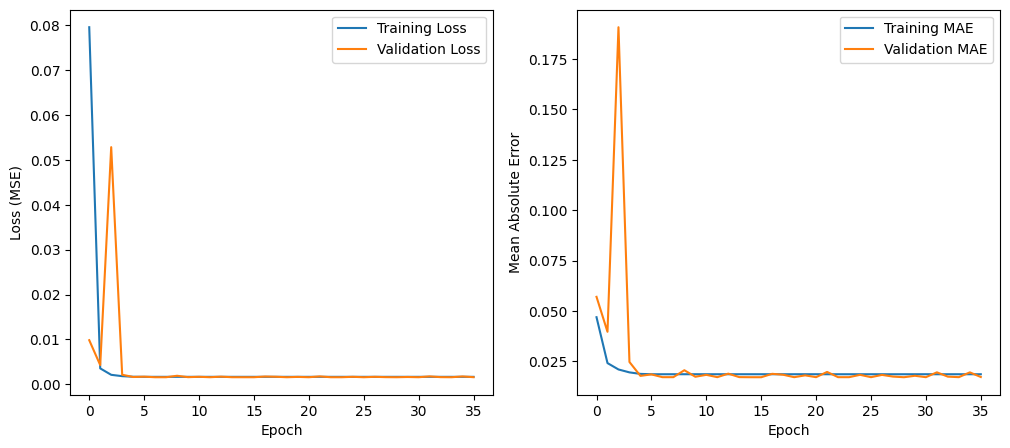

In [ ]:
# Visualize Training History
history_dict = history.history

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

158838/158838 ━━━━━━━━━━━━━━━━━━━━ 319s 2ms/step - loss: 0.0015 - mae: 0.0171
Test Loss (MSE): 0.0015
Test MAE: 0.0171
158838/158838 ━━━━━━━━━━━━━━━━━━━━ 221s 1ms/step


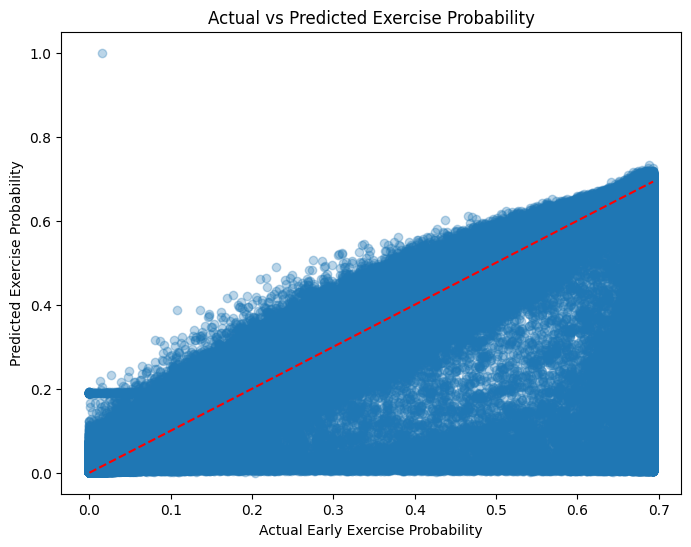

In [ ]:
# Evaluate on Test Set
val_loss, val_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss (MSE): {val_loss:.4f}")
print(f"Test MAE: {val_mae:.4f}")


# Predictions
predictions = model.predict(X_test_scaled).flatten()

# Scatter Plot (Actual vs Predicted)
plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.xlabel('Actual Early Exercise Probability')
plt.ylabel('Predicted Exercise Probability')
plt.title('Actual vs Predicted Exercise Probability')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/Grad Pricing simulations Data Prep Runs 2/Models/early_exercise_model.keras"
model.save(model_path)